In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from keras.optimizers import Adam 
import random

image_dir = '/kaggle/input/face-images-with-marked-landmark-points/face_images.npz'
keypoints_dir = '/kaggle/input/face-images-with-marked-landmark-points/facial_keypoints.csv'

# Load the dataset 
images = np.moveaxis(np.load(image_dir)['face_images'], -1, 0)
facial_keypoints = pd.read_csv(keypoints_dir)

# Standardize the values of images 
images = images/255

Using TensorFlow backend.


In [2]:
# Get the features in the dataset 
features = facial_keypoints.columns.tolist()
num_features = len(features)

# Get the index of all images with non-null values 
selection_index = np.nonzero(facial_keypoints.isnull().sum(axis=1) == 0)[0]
# Number of selections 
m = selection_index.shape[0]
image_dim = images.shape[1]

# Get the matching image samples 
image_samples = np.zeros((m, image_dim, image_dim,1))
image_samples[:,:,:,0] = images[selection_index,:,:]
# Get the keypoints for the samples and standardize the results 
keypoints = np.zeros((m, num_features))
# Save the keypoints of the selected samples 
for idx, column in enumerate(facial_keypoints): 
    keypoints[:,idx] = facial_keypoints[column][selection_index].values/image_dim
print(keypoints.shape)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


(2140, 30)


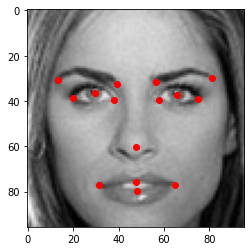

In [3]:
# Plot a random image with facial keypoints 
index = random.randint(0, m)
plt.imshow(image_samples[index,:,:,0], cmap='gray')
# Add the features 
for i in range(0,num_features,2): 
    x_pos = keypoints[index,i] * image_dim
    y_pos = keypoints[index,i+1] * image_dim
    plt.plot(x_pos, y_pos, 'ro')

In [4]:
# Split the dataset 
split_ratio = 0.95
split_selection = np.squeeze(np.random.rand(1,m) < split_ratio) # split the dataset into training and testing subsets
train_selection = np.nonzero(split_selection)[0]
test_selection = np.where(split_selection == False)[0]

# Load the training dataset 
images_train = image_samples[train_selection]
keypoints_train = keypoints[train_selection,:]
m_train = images_train.shape[0] # Number of training samples 
# Load the testing dataset 
images_test = image_samples[test_selection]
keypoints_test = keypoints[test_selection,:]
m_test = images_test.shape[0]

print('Number of training samples:', m_train)
print('Number of testing samples:', m_test)


Number of training samples: 2033
Number of testing samples: 107


In [12]:
# Create a new model 
def create_model(parameters): 
    model = Sequential() 
    
    # Add the first block 
    model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=parameters['input_size']))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate = 0.8))
    
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=parameters['input_size']))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(rate = 0.75))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(890, activation = 'relu'))
    model.add(Dropout(rate = 0.7))
    
    model.add(Dense(324, activation = 'relu'))
    
    model.add(Dense(num_features, activation = 'sigmoid'))
        
    if parameters['get_summary'] is True:
        model.summary()
    
    return model 

model = create_model({
    'input_size': (image_dim, image_dim, 1),
    'get_summary': True
})

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_13 (Activation)   (None, 12, 12, 64)       

In [ ]:
# Compile the model 
model.compile(optimizer=Adam(learning_rate=0.01, beta_1 = 0.9, beta_2 = 0.999), loss = 'mean_squared_error', metrics = ['accuracy'])
# Fit the model 
model.fit(images_train, keypoints_train, 
         validation_data = (images_test, keypoints_test), 
         epochs = 30, batch_size = 64, verbose=1)

Train on 2033 samples, validate on 107 samples
Epoch 1/30
2033/2033 [==============================] - 9s 5ms/step - loss: 0.0208 - accuracy: 0.3802 - val_loss: 0.0211 - val_accuracy: 0.5421
Epoch 2/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0050 - accuracy: 0.5268 - val_loss: 0.0150 - val_accuracy: 0.6542
Epoch 3/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0039 - accuracy: 0.6129 - val_loss: 0.0112 - val_accuracy: 0.6542
Epoch 4/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0034 - accuracy: 0.6242 - val_loss: 0.0109 - val_accuracy: 0.6542
Epoch 5/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0026 - accuracy: 0.6773 - val_loss: 0.0098 - val_accuracy: 0.6542
Epoch 6/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0023 - accuracy: 0.6896 - val_loss: 0.0100 - val_accuracy: 0.6542
Epoch 7/30
2033/2033 [==============================] - 8s 4ms/step - loss: 0.0019 - accu

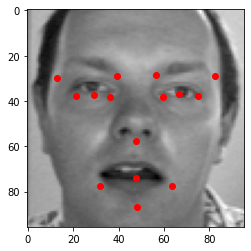

In [9]:
# get a random index 
index = random.randint(0, m_test)
# select random image and make it 4D
image = np.expand_dims(images_test[index], axis=0)
test_preds = model.predict(image)

# Plot the predicts for a random image
plt.imshow(image[0,:,:,0],cmap ='gray')
for i in range(0, num_features, 2):
    # plot the predicts 
    x_pos = test_preds[0,i] * image_dim
    y_pos = test_preds[0,i+1] * image_dim
    plt.plot(x_pos, y_pos, 'ro')